# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups   
Sample_063  A0A286YFJ8;P01861   18.296
Sample_047  P69905              17.553
Sample_084  P08185              21.068
Sample_000  P10124              17.060
Sample_077  P02649              25.134
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups
Sample_090  Q9NQ30           14.783
Sample_144  Q969Z4           15.985
Sample_113  O95881           11.935
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.698
            A0A075B6Q5                 11.606
            A0A075B6R2                 13.068
            A0A075B6S5                 13.623
            A0A087WSY4                 13.272
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.434
            Q9UI40;Q9UI40-2            12.672
            Q9UIW2                     12.425
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.199
            Q9UP79                     12.618
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.282,15.050,16.842,19.863,15.544,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.481,19.067,...,15.528,15.576,14.030,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.488,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.729,17.705,17.039,15.991,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.305,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.267,15.345,17.084,18.708,14.249,19.433,12.482,11.182
Sample_207,15.739,16.877,15.469,16.898,14.971,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,11.698,...,16.012,15.178,12.706,15.050,16.842,19.863,12.769,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.862,19.067,16.188,...,15.528,15.576,11.936,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.926,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.027,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.378,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.919,15.345,17.084,18.708,14.249,19.433,12.183,12.181
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 359.47it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

100%|██████████| 2/2 [00:00<00:00,  2.61it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.97it/s]

100%|██████████| 3/3 [00:00<00:00,  2.97it/s]

100%|██████████| 3/3 [00:00<00:00,  3.09it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.87it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.60it/s]

100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:01,  2.88it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.22it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.18it/s]

100%|██████████| 5/5 [00:02<00:00,  2.12it/s]

100%|██████████| 5/5 [00:02<00:00,  2.21it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.96it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.84it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.70it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.42it/s]

100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

100%|██████████| 6/6 [00:02<00:00,  2.67it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.27it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.33it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.15it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.01it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.89it/s]

100%|██████████| 7/7 [00:02<00:00,  2.88it/s]

100%|██████████| 7/7 [00:02<00:00,  3.09it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:02,  2.99it/s]

 38%|███▊      | 3/8 [00:01<00:02,  2.31it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.14it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.36it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.25it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

100%|██████████| 8/8 [00:03<00:00,  2.22it/s]

100%|██████████| 8/8 [00:03<00:00,  2.28it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:02,  3.48it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.52it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.11it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.04it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.96it/s]

 78%|███████▊  | 7/9 [00:03<00:00,  2.25it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.99it/s]

100%|██████████| 9/9 [00:04<00:00,  1.87it/s]

100%|██████████| 9/9 [00:04<00:00,  2.07it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.65it/s]

 30%|███       | 3/10 [00:00<00:02,  3.40it/s]

 40%|████      | 4/10 [00:01<00:02,  2.37it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.23it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.13it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.21it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.13it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.02it/s]

100%|██████████| 10/10 [00:04<00:00,  1.90it/s]

100%|██████████| 10/10 [00:04<00:00,  2.20it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.78it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.29it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.81it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.65it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.53it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.54it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.51it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.42it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.52it/s]

100%|██████████| 11/11 [00:04<00:00,  2.55it/s]

100%|██████████| 11/11 [00:04<00:00,  2.66it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.65it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.86it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.64it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.40it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.34it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  3.06it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.05it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.04it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.90it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.03it/s]

100%|██████████| 12/12 [00:03<00:00,  3.06it/s]

100%|██████████| 12/12 [00:03<00:00,  3.21it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.57it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.43it/s]

 31%|███       | 4/13 [00:00<00:02,  3.69it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.11it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.17it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.13it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.69it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.74it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.88it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.55it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.63it/s]

100%|██████████| 13/13 [00:04<00:00,  2.82it/s]

100%|██████████| 13/13 [00:04<00:00,  3.01it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.19it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.95it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.52it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.40it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.88it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.97it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.63it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.78it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.89it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.91it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.89it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.96it/s]

100%|██████████| 14/14 [00:04<00:00,  3.09it/s]

100%|██████████| 14/14 [00:04<00:00,  3.08it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.41it/s]

 20%|██        | 3/15 [00:00<00:03,  3.17it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.08it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.10it/s]

 40%|████      | 6/15 [00:01<00:02,  3.20it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.80it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.68it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.71it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.88it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.98it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.02it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.11it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.76it/s]

100%|██████████| 15/15 [00:05<00:00,  2.59it/s]

100%|██████████| 15/15 [00:05<00:00,  2.90it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.076 0.025          0.705 0.393       0.098   
2             0.005 0.004      0.078 0.036          0.666 0.100       0.529   
3             0.007 0.006      0.093 0.043          0.758 0.095       0.674   
4             0.005 0.005      0.067 0.024          0.754 0.094       0.712   
5             0.005 0.004      0.063 0.025          0.795 0.083       0.738   
6             0.008 0.007      0.100 0.040          0.811 0.079       0.743   
7             0.006 0.005      0.076 0.026          0.811 0.082       0.747   
8             0.006 0.006      0.062 0.023          0.820 0.083       0.833   
9             0.006 0.005      0.078 0.040          0.823 0.081       0.837   
10            0.008 0.007      0.090 0.033          0.827 0.080       0.831   
11            0.004 0.001      0.050 0.011          0.816 0.086       0.822   
12            0.004 0.002      0.054 0.017          0.813 0.089       0.821   
13            0.005 0.003      0.053 0.014          0.810 0.084       0.819   
14            0.005 0.003      0.054 0.016          0.805 0.083       0.818   
15            0.005 0.003      0.050 0.012          0.820 0.073       0.810   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.078   0.167 0.120                  0.542 0.036        0.850   
2          0.107   0.581 0.077                  0.663 0.052        0.730   
3          0.124   0.707 0.088                  0.756 0.069        0.830   
4          0.131   0.724 0.089                  0.769 0.069        0.842   
5          0.090   0.761 0.066                  0.798 0.053        0.858   
6          0.082   0.772 0.061                  0.807 0.050        0.865   
7          0.089   0.773 0.064                  0.808 0.052        0.863   
8          0.098   0.822 0.065                  0.848 0.056        0.910   
9          0.103   0.825 0.069                  0.851 0.060        0.910   
10         0.103   0.824 0.066                  0.850 0.056        0.909   
11         0.109   0.813 0.073                  0.841 0.062        0.907   
12         0.109   0.812 0.075                  0.840 0.064        0.906   
13         0.103   0.810 0.071                  0.837 0.061        0.904   
14         0.103   0.807 0.072                  0.835 0.062        0.903   
15         0.104   0.810 0.068                  0.839 0.057        0.909   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.823 0.089        210.000 0.000  
2          0.073                  0.669 0.090        210.000 0.000  
3          0.065                  0.807 0.079        210.000 0.000  
4          0.061                  0.826 0.065        210.000 0.000  
5          0.061                  0.846 0.069        210.000 0.000  
6          0.062                  0.846 0.072        210.000 0.000  
7          0.062                  0.844 0.071        210.000 0.000  
8          0.049                  0.899 0.050        210.000 0.000  
9          0.050                  0.900 0.051        210.000 0.000  
10         0.050                  0.896 0.054        210.000 0.000  
11         0.051                  0.894 0.054        210.000 0.000  
12         0.051                  0.894 0.053        210.000 0.000  
13         0.052                  0.890 0.055        210.000 0.000  
14         0.051                  0.888 0.055        210.000 0.000  
15         0.050                  0.891 0.055 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 477.22it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.46it/s]

100%|██████████| 2/2 [00:00<00:00,  5.42it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.41it/s]

100%|██████████| 3/3 [00:00<00:00,  3.50it/s]

100%|██████████| 3/3 [00:00<00:00,  3.60it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.47it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.23it/s]

100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

100%|██████████| 4/4 [00:01<00:00,  3.11it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.36it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.91it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.27it/s]

100%|██████████| 5/5 [00:01<00:00,  2.80it/s]

100%|██████████| 5/5 [00:01<00:00,  3.18it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.35it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.91it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.31it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  1.98it/s]

100%|██████████| 6/6 [00:02<00:00,  1.69it/s]

100%|██████████| 6/6 [00:02<00:00,  2.02it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.44it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.53it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.82it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.67it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.16it/s]

100%|██████████| 7/7 [00:02<00:00,  1.96it/s]

100%|██████████| 7/7 [00:02<00:00,  2.37it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.51it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.46it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.11it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.80it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.81it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.58it/s]

100%|██████████| 8/8 [00:02<00:00,  3.66it/s]

100%|██████████| 8/8 [00:02<00:00,  3.88it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.57it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.59it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.84it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.35it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.27it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.15it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.98it/s]

100%|██████████| 9/9 [00:02<00:00,  2.81it/s]

100%|██████████| 9/9 [00:02<00:00,  3.26it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.83it/s]

 30%|███       | 3/10 [00:00<00:01,  4.31it/s]

 40%|████      | 4/10 [00:00<00:01,  3.72it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.64it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.67it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.29it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.23it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.13it/s]

100%|██████████| 10/10 [00:03<00:00,  2.01it/s]

100%|██████████| 10/10 [00:03<00:00,  2.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:03,  2.67it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

 36%|███▋      | 4/11 [00:01<00:03,  1.91it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.11it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.34it/s]

 64%|██████▎   | 7/11 [00:03<00:01,  2.46it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.58it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.62it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.70it/s]

100%|██████████| 11/11 [00:04<00:00,  2.78it/s]

100%|██████████| 11/11 [00:04<00:00,  2.46it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.67it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.41it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.42it/s]

 42%|████▏     | 5/12 [00:02<00:03,  1.90it/s]

 50%|█████     | 6/12 [00:02<00:03,  1.69it/s]

 58%|█████▊    | 7/12 [00:03<00:03,  1.66it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.84it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.94it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.13it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  2.29it/s]

100%|██████████| 12/12 [00:05<00:00,  2.42it/s]

100%|██████████| 12/12 [00:05<00:00,  2.20it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.85it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.21it/s]

 31%|███       | 4/13 [00:01<00:02,  3.08it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.87it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.93it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.79it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.64it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.30it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.06it/s]

 85%|████████▍ | 11/13 [00:04<00:01,  1.98it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.86it/s]

100%|██████████| 13/13 [00:05<00:00,  1.74it/s]

100%|██████████| 13/13 [00:05<00:00,  2.27it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.68it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.49it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.98it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.37it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.09it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.13it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.15it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.31it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.44it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.30it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.43it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.49it/s]

100%|██████████| 14/14 [00:05<00:00,  2.52it/s]

100%|██████████| 14/14 [00:05<00:00,  2.48it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.88it/s]

 20%|██        | 3/15 [00:00<00:03,  3.55it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.98it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.89it/s]

 40%|████      | 6/15 [00:02<00:03,  2.68it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.56it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.24it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.07it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.04it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.07it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.15it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.19it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.34it/s]

100%|██████████| 15/15 [00:06<00:00,  2.20it/s]

100%|██████████| 15/15 [00:06<00:00,  2.38it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.052 0.009          0.000 0.000       0.000   
2             0.004 0.003      0.053 0.016          0.775 0.117       0.597   
3             0.004 0.002      0.052 0.012          0.736 0.122       0.556   
4             0.004 0.003      0.052 0.012          0.729 0.119       0.582   
5             0.006 0.005      0.076 0.028          0.720 0.094       0.628   
6             0.009 0.008      0.095 0.041          0.751 0.099       0.684   
7             0.005 0.004      0.057 0.020          0.737 0.098       0.667   
8             0.003 0.002      0.033 0.007          0.784 0.100       0.742   
9             0.004 0.000      0.043 0.002          0.783 0.104       0.754   
10            0.004 0.002      0.063 0.023          0.781 0.101       0.754   
11            0.007 0.007      0.073 0.033          0.785 0.103       0.767   
12            0.005 0.003      0.059 0.027          0.780 0.098       0.789   
13            0.005 0.003      0.059 0.023          0.801 0.089       0.786   
14            0.005 0.004      0.060 0.019          0.803 0.091       0.773   
15            0.006 0.005      0.063 0.029          0.820 0.089       0.786   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.497 0.008        0.853   
2          0.133   0.664 0.102                  0.731 0.071        0.777   
3          0.136   0.623 0.108                  0.702 0.071        0.774   
4          0.126   0.638 0.102                  0.709 0.068        0.775   
5          0.117   0.663 0.082                  0.722 0.060        0.785   
6          0.131   0.709 0.096                  0.758 0.074        0.845   
7          0.123   0.694 0.091                  0.745 0.069        0.853   
8          0.117   0.755 0.079                  0.793 0.065        0.905   
9          0.109   0.761 0.079                  0.797 0.066        0.904   
10         0.109   0.760 0.077                  0.796 0.064        0.902   
11         0.109   0.770 0.079                  0.804 0.067        0.902   
12         0.116   0.778 0.081                  0.810 0.068        0.909   
13         0.112   0.788 0.080                  0.820 0.066        0.915   
14         0.112   0.781 0.078                  0.815 0.064        0.916   
15         0.109   0.797 0.077                  0.828 0.065        0.921   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.824 0.088        210.000 0.000  
2          0.078                  0.729 0.094        210.000 0.000  
3          0.077                  0.735 0.093        210.000 0.000  
4          0.074                  0.719 0.093        210.000 0.000  
5          0.069                  0.750 0.089        210.000 0.000  
6          0.058                  0.819 0.066        210.000 0.000  
7          0.059                  0.826 0.069        210.000 0.000  
8          0.048                  0.885 0.055        210.000 0.000  
9          0.051                  0.885 0.057        210.000 0.000  
10         0.051                  0.883 0.057        210.000 0.000  
11         0.051                  0.885 0.057        210.000 0.000  
12         0.048                  0.892 0.054        210.000 0.000  
13         0.048                  0.898 0.052        210.000 0.000  
14         0.046                  0.900 0.049        210.000 0.000  
15         0.044                  0.906 0.047 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 967.77it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 23.51it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 18.54it/s]

100%|██████████| 3/3 [00:00<00:00, 18.24it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 17.99it/s]

100%|██████████| 4/4 [00:00<00:00, 14.08it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 17.88it/s]

100%|██████████| 5/5 [00:00<00:00, 12.75it/s]

100%|██████████| 5/5 [00:00<00:00, 13.43it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 18.75it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 13.08it/s]

100%|██████████| 6/6 [00:00<00:00, 13.51it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 18.36it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 12.96it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 11.44it/s]

100%|██████████| 7/7 [00:00<00:00, 12.44it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 17.59it/s]

 50%|█████     | 4/8 [00:00<00:00, 13.93it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 11.93it/s]

100%|██████████| 8/8 [00:00<00:00, 11.68it/s]

100%|██████████| 8/8 [00:00<00:00, 12.23it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 20.52it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 14.57it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 14.26it/s]

100%|██████████| 9/9 [00:00<00:00, 14.14it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 21.68it/s]

 60%|██████    | 6/10 [00:00<00:00, 14.16it/s]

 80%|████████  | 8/10 [00:00<00:00, 12.58it/s]

100%|██████████| 10/10 [00:00<00:00, 12.89it/s]

100%|██████████| 10/10 [00:00<00:00, 13.47it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 16.18it/s]

 45%|████▌     | 5/11 [00:00<00:00, 13.15it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 12.09it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 11.23it/s]

100%|██████████| 11/11 [00:00<00:00, 11.93it/s]

100%|██████████| 11/11 [00:00<00:00, 12.05it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 17.15it/s]

 42%|████▏     | 5/12 [00:00<00:00, 13.30it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 12.70it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 12.30it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 11.31it/s]

100%|██████████| 12/12 [00:00<00:00, 12.15it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 15.00it/s]

 38%|███▊      | 5/13 [00:00<00:00, 14.23it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 12.14it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 11.70it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 11.41it/s]

100%|██████████| 13/13 [00:01<00:00, 11.74it/s]

100%|██████████| 13/13 [00:01<00:00, 12.09it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 15.85it/s]

 36%|███▌      | 5/14 [00:00<00:00, 11.67it/s]

 50%|█████     | 7/14 [00:00<00:00, 12.21it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 11.41it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 11.59it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 10.85it/s]

100%|██████████| 14/14 [00:01<00:00, 11.28it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 18.64it/s]

 33%|███▎      | 5/15 [00:00<00:00, 14.23it/s]

 47%|████▋     | 7/15 [00:00<00:00, 12.83it/s]

 60%|██████    | 9/15 [00:00<00:00, 12.70it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 13.01it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 13.24it/s]

100%|██████████| 15/15 [00:01<00:00, 13.65it/s]

100%|██████████| 15/15 [00:01<00:00, 13.56it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.062 0.019          0.000 0.000       0.000   
2             0.005 0.004      0.068 0.026          0.687 0.123       0.480   
3             0.005 0.004      0.060 0.020          0.674 0.117       0.462   
4             0.006 0.005      0.062 0.021          0.724 0.116       0.463   
5             0.005 0.005      0.065 0.026          0.708 0.122       0.447   
6             0.004 0.002      0.057 0.023          0.687 0.119       0.440   
7             0.004 0.003      0.066 0.029          0.659 0.100       0.557   
8             0.006 0.005      0.065 0.025          0.668 0.098       0.577   
9             0.004 0.003      0.061 0.027          0.684 0.102       0.597   
10            0.006 0.007      0.062 0.027          0.676 0.103       0.590   
11            0.006 0.005      0.068 0.028          0.675 0.097       0.621   
12            0.006 0.005      0.071 0.027          0.660 0.091       0.608   
13            0.005 0.004      0.064 0.024          0.654 0.085       0.597   
14            0.005 0.004      0.064 0.029          0.668 0.090       0.599   
15            0.006 0.005      0.076 0.037          0.661 0.090       0.594   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.735   
2          0.110   0.557 0.098                  0.657 0.064        0.733   
3          0.110   0.541 0.100                  0.647 0.064        0.728   
4          0.116   0.555 0.095                  0.663 0.058        0.742   
5          0.120   0.537 0.100                  0.652 0.062        0.734   
6          0.121   0.527 0.105                  0.645 0.065        0.730   
7          0.136   0.596 0.101                  0.673 0.072        0.774   
8          0.125   0.612 0.091                  0.682 0.069        0.770   
9          0.122   0.631 0.089                  0.696 0.068        0.777   
10         0.124   0.623 0.091                  0.689 0.068        0.773   
11         0.131   0.640 0.096                  0.700 0.075        0.786   
12         0.122   0.626 0.088                  0.688 0.067        0.783   
13         0.115   0.618 0.084                  0.682 0.067        0.785   
14         0.113   0.625 0.082                  0.689 0.065        0.788   
15         0.110   0.619 0.079                  0.684 0.063        0.782   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.069                  0.683 0.086        210.000 0.000  
2          0.071                  0.667 0.088        210.000 0.000  
3          0.070                  0.663 0.086        210.000 0.000  
4          0.073                  0.670 0.088        210.000 0.000  
5          0.076                  0.657 0.092        210.000 0.000  
6          0.076                  0.654 0.091        210.000 0.000  
7          0.074                  0.716 0.090        210.000 0.000  
8          0.077                  0.711 0.092        210.000 0.000  
9          0.078                  0.716 0.095        210.000 0.000  
10         0.076                  0.717 0.092        210.000 0.000  
11         0.074                  0.726 0.091        210.000 0.000  
12         0.074                  0.721 0.090        210.000 0.000  
13         0.069                  0.726 0.090        210.000 0.000  
14         0.072                  0.730 0.093        210.000 0.000  
15         0.075                  0.728 0.095 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,6,6,10
score_time,6,6,15
test_precision,10,15,4
test_recall,9,12,11
test_f1,9,15,11
test_balanced_accuracy,9,15,11
test_roc_auc,9,15,14
test_average_precision,9,15,14
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:04,  2.98it/s]

 20%|██        | 3/15 [00:01<00:06,  1.96it/s]

 27%|██▋       | 4/15 [00:02<00:06,  1.72it/s]

 33%|███▎      | 5/15 [00:02<00:05,  1.81it/s]

 40%|████      | 6/15 [00:03<00:04,  1.91it/s]

 47%|████▋     | 7/15 [00:03<00:03,  2.10it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.30it/s]

 60%|██████    | 9/15 [00:04<00:02,  2.45it/s]

 67%|██████▋   | 10/15 [00:04<00:01,  2.60it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.70it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.74it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.75it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.82it/s]

100%|██████████| 15/15 [00:06<00:00,  2.53it/s]

100%|██████████| 15/15 [00:06<00:00,  2.35it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 16.37it/s]

 29%|██▊       | 4/14 [00:00<00:00, 10.60it/s]

 43%|████▎     | 6/14 [00:00<00:00,  9.80it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  9.36it/s]

 64%|██████▍   | 9/14 [00:00<00:00,  9.09it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  9.09it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  9.29it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  9.02it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  9.01it/s]

100%|██████████| 14/14 [00:01<00:00,  9.07it/s]

100%|██████████| 14/14 [00:01<00:00,  9.42it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.18it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.96it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.91it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.58it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.31it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.28it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.26it/s]

100%|██████████| 9/9 [00:02<00:00,  3.19it/s]

100%|██████████| 9/9 [00:02<00:00,  3.54it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


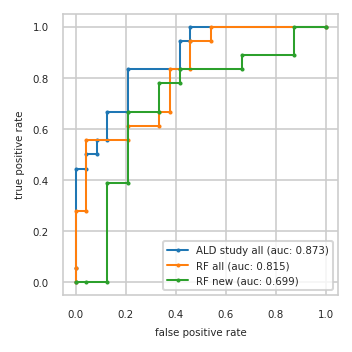

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.444  0.000 0.278  0.125 0.000
3          0.042 0.444  0.042 0.278  0.125 0.389
4          0.042 0.500  0.042 0.556  0.208 0.389
5          0.083 0.500  0.208 0.556  0.208 0.667
6          0.083 0.556  0.208 0.611  0.333 0.667
7          0.125 0.556  0.333 0.611  0.333 0.778
8          0.125 0.667  0.333 0.667  0.417 0.778
9          0.208 0.667  0.375 0.667  0.417 0.833
10         0.208 0.833  0.375 0.833  0.667 0.833
11         0.417 0.833  0.458 0.833  0.667 0.889
12         0.417 0.944  0.458 0.944  0.875 0.889
13         0.458 0.944  0.542 0.944  0.875 1.000
14         0.458 1.000  0.542 1.000  1.000 1.000
15         1.000 1.000  1.000 1.000    NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,Q14894
1,K7ER15;Q9H0R4;Q9H0R4-2,P31150,J3KSJ8;Q9UD71;Q9UD71-2
2,P02741,P25189;P25189-2,P30048;P30048-2
3,P61981,P10636-2;P10636-6,A0A0J9YW36;Q9NZ72;Q9NZ72-2
4,P04075,P08670,P31321
5,P14174,P04075,Q96GD0
6,P05160,P14174,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,P00338;P00338-3,P61981,Q9NUQ9
8,Q9Y2T3;Q9Y2T3-3,P15151-2,O95497


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


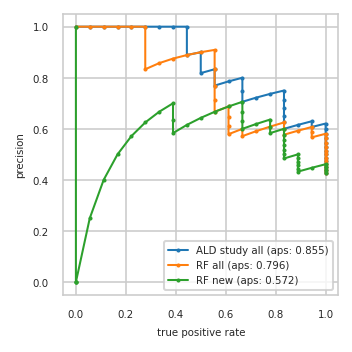

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.432 0.889
6          0.500 1.000     0.500 1.000     0.444 0.889
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.562 1.000     0.500 0.889
11         0.581 1.000     0.581 1.000     0.484 0.833
12         0.600 1.000     0.567 0.944     0.500 0.833
13         0.621 1.000     0.586 0.944     0.517 0.833
14         0.607 0.944     0.607 0.944     0.536 0.833
15         0.630 0.944     0.593 0.889     0.556 0.833
16         0.615 0.889     0.577 0.833     0.577 0.833
17         0.600 0.833     0.600 0.833     0.600 0.833
18         0.625 0.833     0.625 0.833     0.583 0.778
19         0.652 0.833     0.609 0.778     0.609 0.778
20         0.682 0.833     0.591 0.722     0.636 0.778
21         0.714 0.833     0.571 0.667     0.619 0.722
22         0.750 0.833     0.600 0.667     0.600 0.667
23         0.737 0.778     0.579 0.611     0.632 0.667
24         0.722 0.722     0.611 0.611     0.667 0.667
25         0.706 0.667     0.647 0.611     0.706 0.667
26         0.750 0.667     0.688 0.611     0.688 0.611
27         0.800 0.667     0.667 0.556     0.667 0.556
28         0.786 0.611     0.714 0.556     0.643 0.500
29         0.769 0.556     0.769 0.556     0.615 0.444
30         0.833 0.556     0.833 0.556     0.583 0.389
31         0.818 0.500     0.909 0.556     0.636 0.389
32         0.900 0.500     0.900 0.500     0.700 0.389
33         0.889 0.444     0.889 0.444     0.667 0.333
34         1.000 0.444     0.875 0.389     0.625 0.278
35         1.000 0.389     0.857 0.333     0.571 0.222
36         1.000 0.333     0.833 0.278     0.500 0.167
37         1.000 0.278     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.250 0.056
39         1.000 0.167     1.000 0.167     0.000 0.000
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


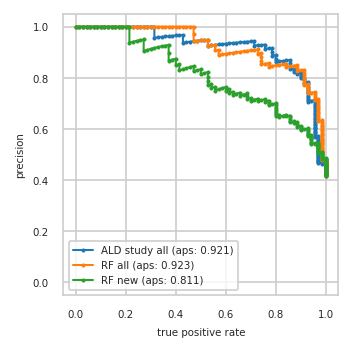

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


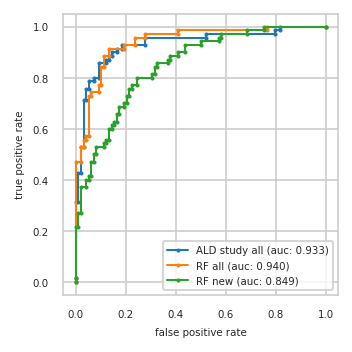

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}